In [124]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
import random

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import seaborn as sns

# from scfair.evaluate import *
# from scfair_reproducibility.evaluation.metrics import *

from dis2p import dis2pvi_cE as dvi
#import biolord
from data.biolord_dev.src import biolord
from scvi.model.base import BaseModelClass

#from scib_metrics.benchmark import Benchmarker

from sklearn.metrics import r2_score

from scDisInFact import scdisinfact, create_scdisinfact_dataset


Global seed set to 0


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
adata = sc.read_h5ad('data/eraslan_preprocessed1200_split.h5ad')
adata_biolord = sc.read_h5ad('data/eraslan_preprocessed1200_split.h5ad')
adata.var.index = adata.var["gene_name"]
adata_biolord.var.index = adata_biolord.var["gene_name"]


In [126]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata


In [127]:
# specify name of dataset 
data_name = 'eraslan'

# specify attributes
cats = ['tissue', 'Sample ID', 'Broad cell type', 'sex', 'Age_bin']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

today = datetime.today().strftime('%Y-%m-%d')
today

'2024-04-14'

In [128]:
# cats = ['tissue', 'Sample ID', 'Broad cell type', 'sex', 'Age_bin']
# pre_path = 'models/dis2p_cE/'
# model_name = 'cf20beta1/'
# # model_name = 'fine_tuned_regLoss_ood/'
# # model_name = 'fine_tuned_regLoss/'
# model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

In [129]:
#Dis2pvi_cE  (Regular loss)
arch_dict = {'n_layers': 2,
 'n_hidden': 1024,
 'n_latent_shared': 40,
 'n_latent_attribute': 40,
 'dropout_rate': 0.2,
}

train_dict = {
 'max_epochs': 2000,
 'batch_size': 512,
 'cf_weight': 2.18,
 'beta': 0.436,
 'clf_weight': 90.12,
 'adv_clf_weight': 1200, #2000 bad, #1500 decent,     #6.87,
 'adv_period': 2,
 'n_cf': 3,
}
plan_kwargs = {
 'lr': 0.0001,
 'weight_decay': 0.000076
}

module_name = 'dis2p_cE'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

In [ ]:


# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={arch_dict["n_layers"]},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
dvi.Dis2pVI_cE.setup_anndata(
    adata,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)
dis2p_model = dvi.Dis2pVI_cE(adata, n_layers=arch_dict["n_layers"])
dis2p_model.train(**train_dict)
dis2p_model.save(f"{pre_path}/{model_name}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 67/2000:   3%| | 66/2000 [28:08<13:10:24, 24.52s/it, v_num=1, loss_validation=2.45e+3, x_0_validation=179, x_1_validation=187, x_2_validation=184, x_3_v

In [131]:
# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = dis2p_model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = dis2p_model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = dis2p_model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

In [137]:
1+1

2

---UMAP for dis2p_cE_Z_0---


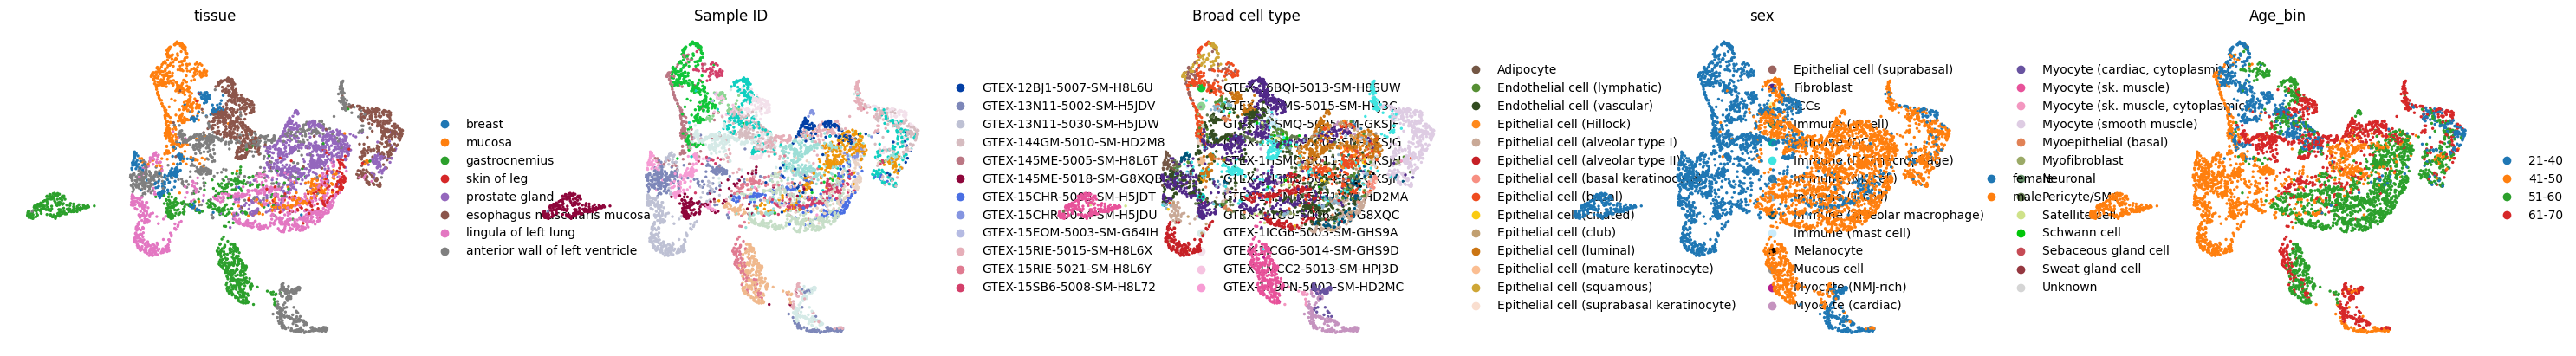

---UMAP for dis2p_cE_Z_1---
tissue


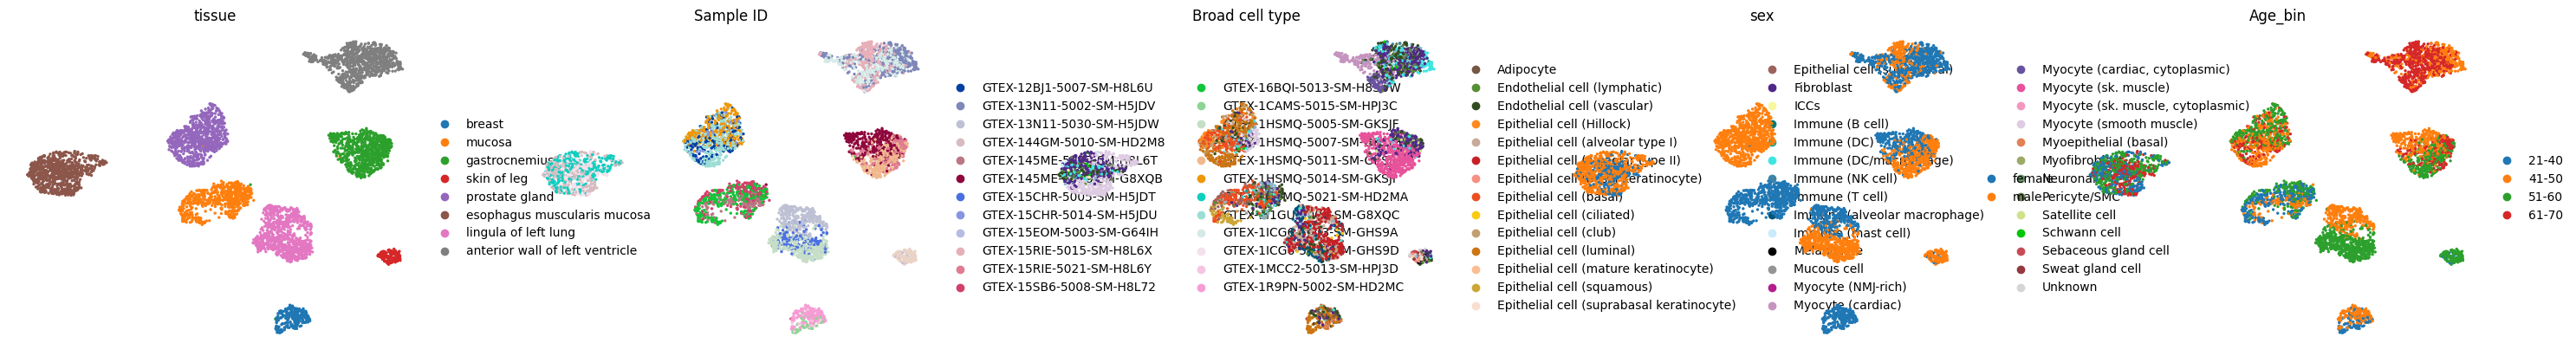

---UMAP for dis2p_cE_Z_2---
Sample ID


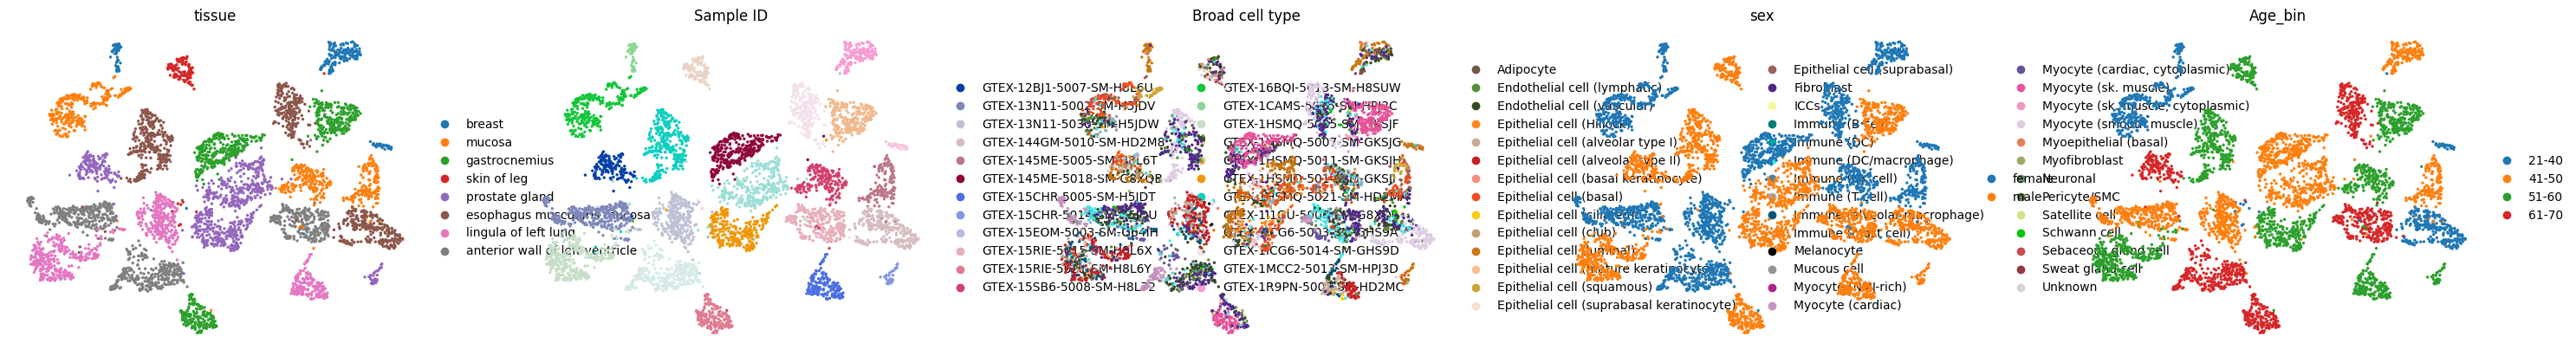

---UMAP for dis2p_cE_Z_3---
Broad cell type


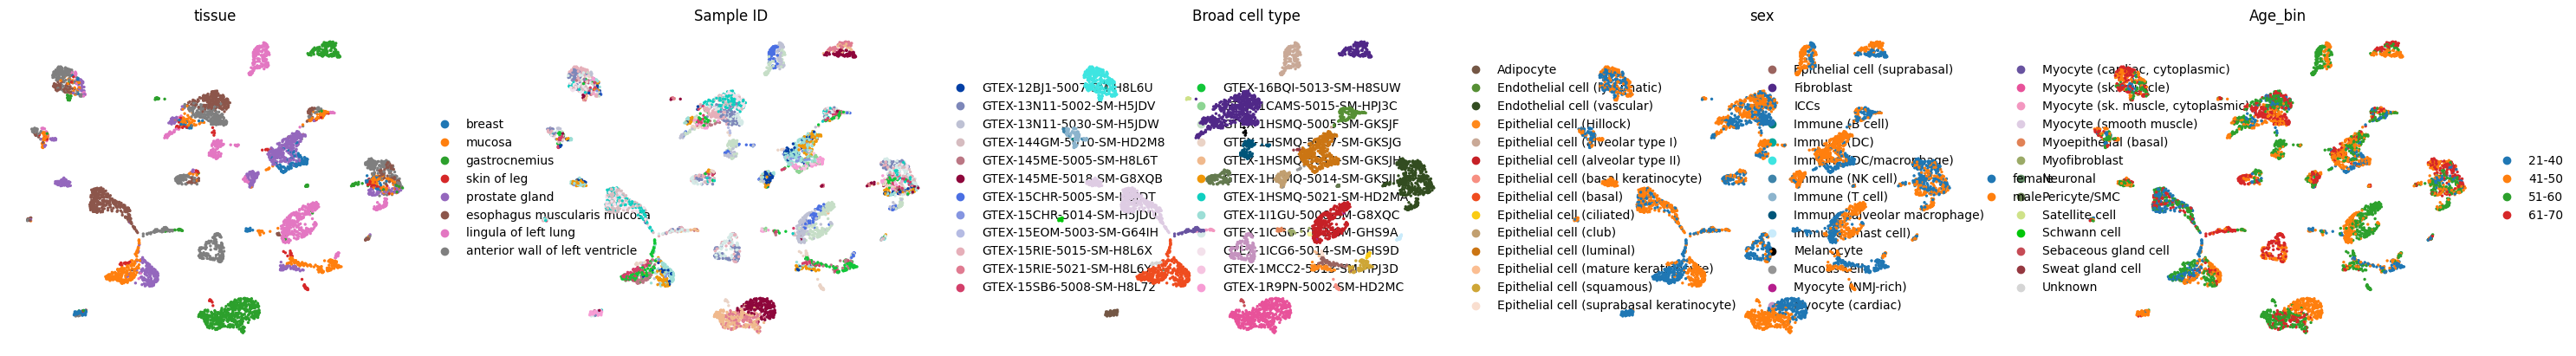

---UMAP for dis2p_cE_Z_4---
sex


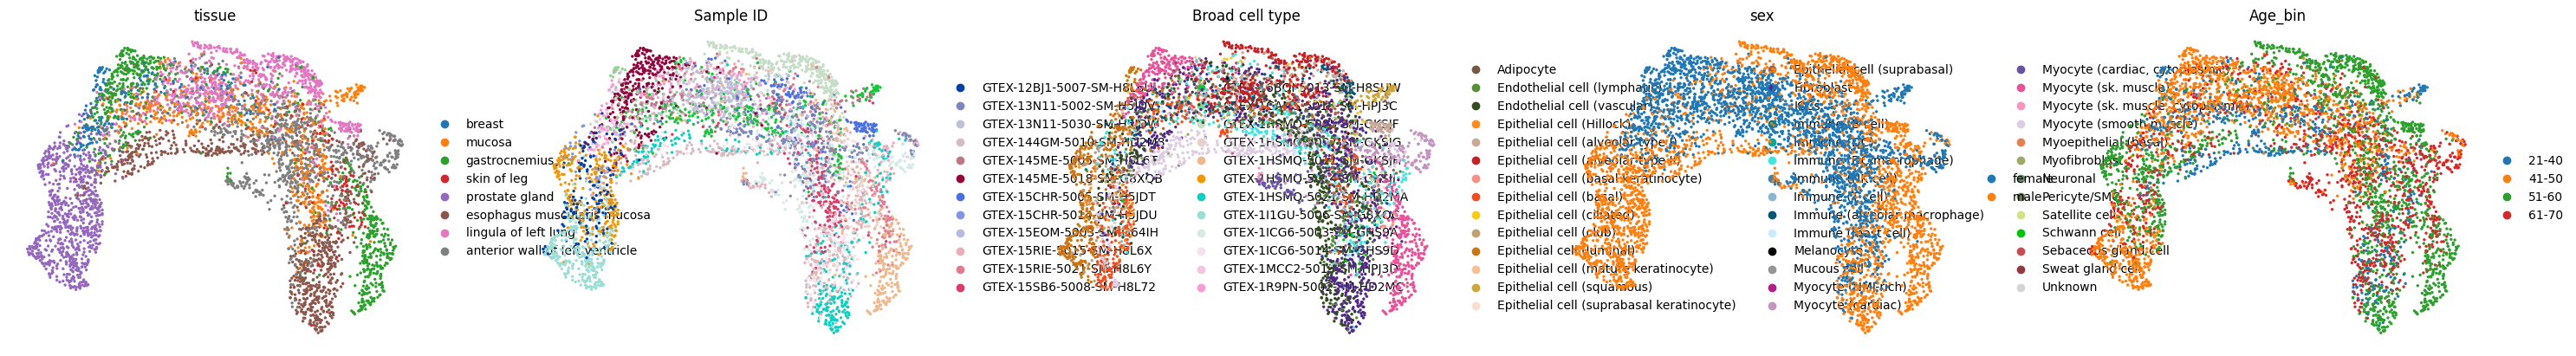

---UMAP for dis2p_cE_Z_5---
Age_bin


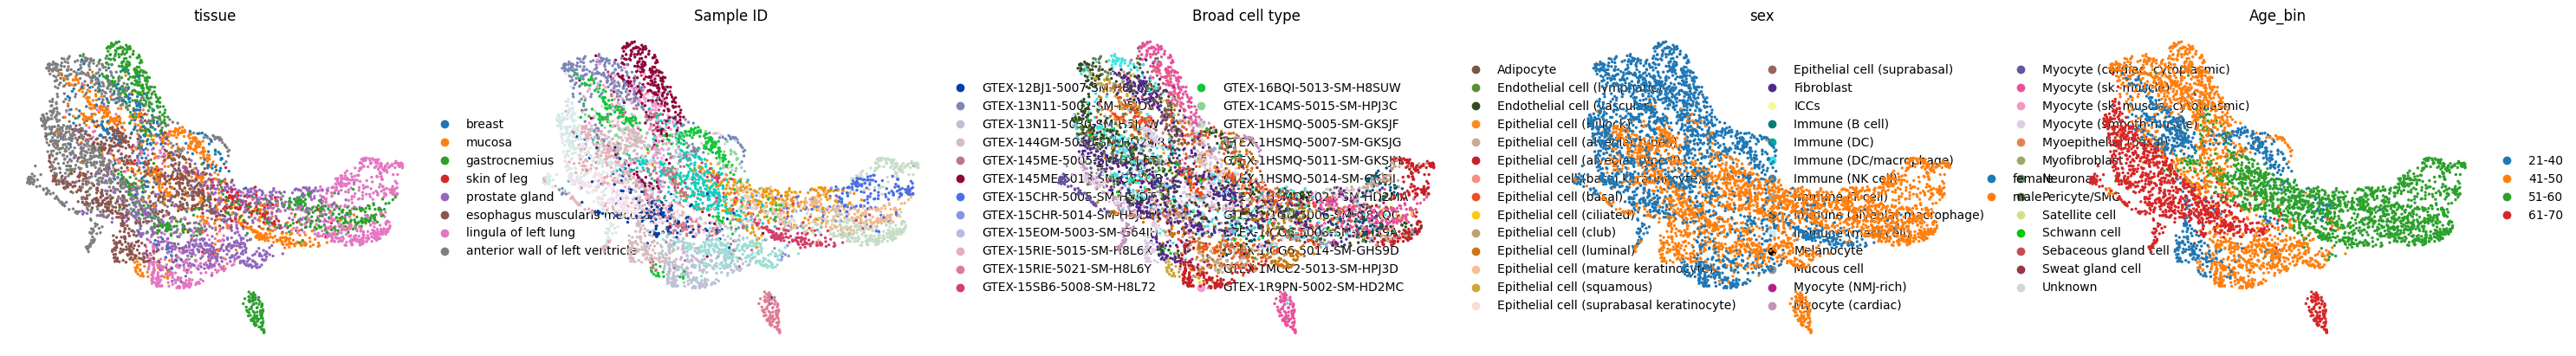

In [132]:
import warnings
warnings.filterwarnings("ignore")
import random
sample = random.sample(range(len(adata)), 5000)

nrow = len(cats) + 1
ncol = len(cats)
# fig, axs = plt.subplots(nrow, ncol, figsize=(2 * ncol, 2 * nrow))

for i in range(len(cats) + 1):  # loop over all Z_i
    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")
    if i != 0:
        print(cats[i - 1])
    adata_ = adata[sample]
    sc.pp.neighbors(adata_, use_rep=f"{latent_name}")
    sc.tl.umap(adata_)

    sc.pl.umap(
        adata_,
        color=cats,
        ncols=len(cats),
        frameon=False,
        # ax=axs[i][:]
    )

In [133]:
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={arch_dict["n_layers"]},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())
dis2p_model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)


INFO     File                                                                                                      
         models/dis2p_cE/2024-04-14,dis2p_cE,eraslan,n_layers=2,max_epochs=2000,batch_size=512,cf_weight=2.18,beta=
         0.436,clf_weight=90.12,adv_clf_weight=1200,adv_period=2,n_cf=3/model.pt already downloaded                


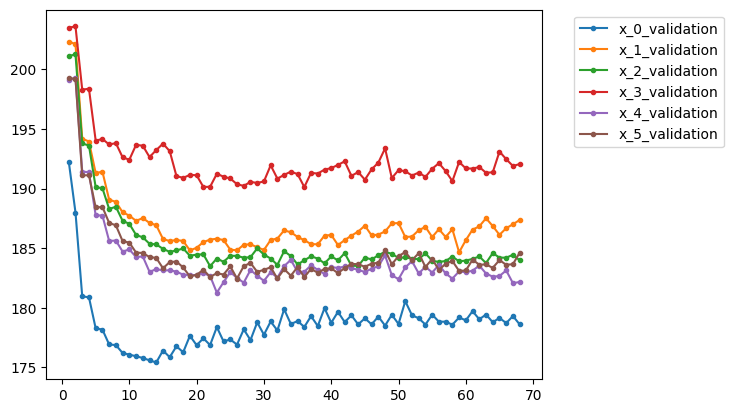

In [134]:
# Assuming you have defined model.history as a dictionary with keys as labels and values as data

for k, v in dis2p_model.history.items():
    if ('x_' in k) and ('validation' in k) and ('rec' not in k):
        plt.plot(range(1, len(v) + 1), v, '.-', label=k)

# Adjust the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# Train Biolord

In [70]:
from data.biolord_dev.src import biolord
#import biolord

In [62]:
biolord.Biolord.setup_anndata(
    adata=adata_biolord,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts"
)

In [63]:
# params in these cells are taken from here: https://biolord.readthedocs.io/en/latest/tutorials/biolord_omics.html#instantiate-a-biolord-model
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}
biolord_model = biolord.Biolord(
    adata=adata_biolord,
    n_latent=128,
    model_name="eraslan_biolord_new",
    module_params=module_params,
)

Global seed set to 42


In [64]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}
biolord_model.train(
    max_epochs=400,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    enable_checkpointing=False,
    early_stopping_patience=45,
    check_val_every_n_epoch=10,
    num_workers=1,
    #accelerator="gpu"
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 112/400:  28%|▎| 112/400 [17:08<44:05,  9.19s/it, v_num=1, val_generative_mean_accuracy=0.646, val_generative_var_accuracy=-0.0066, val_biolord_metric=0
Monitored metric val_biolord_metric did not improve in the last 45 records. Best score: 0.416. Signaling Trainer to stop.


In [68]:
biolord_model.save(f'models/biolord/biolord_eraslan_{today}')

In [135]:
biolord_model = biolord.Biolord.load(f'models/biolord/biolord_eraslan_{today}', adata=adata_biolord)

INFO     File models/biolord/biolord_eraslan_2024-04-14/model.pt already downloaded                                


Global seed set to 42


# Train scDisInFact

In [138]:
counts = adata.layers['counts']
meta_cells = adata.obs
condition_key = ['tissue', 'cell_type', 'sex', 'Age_bin']
# condition_key = ['tissue', 'Sample ID', 'cell_type', 'sex', 'Age_bin']


data_dict = create_scdisinfact_dataset(counts, meta_cells, condition_key = condition_key, batch_key = "Sample ID")


# declare latent dimensions, we have two condition types, so there are three element corresponding to 
# shared-bio factor, unshared-bio factor for condition 1, unshared-bio factor for condition 2
# default setting of hyper-parameters
reg_mmd_comm = 1e-4
reg_mmd_diff = 1e-4
reg_kl_comm = 1e-5
reg_kl_diff = 1e-2
reg_class = 1
reg_gl = 1

Ks = [8, 2, 2, 2, 2]

batch_size = 64
nepochs = 100
interval = 10
lr = 5e-4
lambs = [reg_mmd_comm, reg_mmd_diff, reg_kl_comm, reg_kl_diff, reg_class, reg_gl]


# training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scdisinfact_model = scdisinfact(data_dict = data_dict, Ks = Ks, batch_size = batch_size, interval = interval, lr = lr, 
                    reg_mmd_comm = reg_mmd_comm, reg_mmd_diff = reg_mmd_diff, reg_gl = reg_gl, reg_class = reg_class, 
                    reg_kl_comm = reg_kl_comm, reg_kl_diff = reg_kl_diff, seed = 0, device = device)
scdisinfact_model.train()

losses = scdisinfact_model.train_model(nepochs = nepochs, recon_loss = "NB")
torch.save(scdisinfact_model.state_dict(), 'models/scDisInfact/' + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")

Sanity check...
Finished.
Create scDisInFact datasets...
Finished.
Epoch 0, Validating Loss: 10.2550
	 loss reconstruction: 0.64227
	 loss kl comm: 0.06854
	 loss kl diff: 1.55250
	 loss mmd common: 247.89265
	 loss mmd diff: 878.81555
	 loss classification: 8.73506
	 loss group lasso diff: 0.74945
GPU memory usage: 983.400879MB
Epoch 10, Validating Loss: 9.2410
	 loss reconstruction: 0.51860
	 loss kl comm: 0.08371
	 loss kl diff: 3.87638
	 loss mmd common: 173.79109
	 loss mmd diff: 1491.86597
	 loss classification: 7.79735
	 loss group lasso diff: 0.71970
GPU memory usage: 983.400879MB
Epoch 20, Validating Loss: 8.4058
	 loss reconstruction: 0.28672
	 loss kl comm: 0.17797
	 loss kl diff: 7.65872
	 loss mmd common: 162.08156
	 loss mmd diff: 1775.82410
	 loss classification: 7.14385
	 loss group lasso diff: 0.70486
GPU memory usage: 983.400879MB
Epoch 30, Validating Loss: 7.9458
	 loss reconstruction: 0.25685
	 loss kl comm: 0.27915
	 loss kl diff: 11.18781
	 loss mmd common: 162.87

In [139]:
torch.save(scdisinfact_model.state_dict(), 'models/scDisInfact/' + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")

In [140]:
scdisinfact_model = torch.load('models/scDisInfact/' + f"model_{Ks}_{lambs}_{batch_size}_{nepochs}_{lr}.pth")


# SCIB analysis

In [ ]:
for i, c in enumerate(cats):
    nullify_attribute = [cat for cat in cats if cat != c]
    _, latent_adata = model.get_latent_representation_adata(adata=adata, nullify_attribute=nullify_attribute)
    adata.obsm[f"biolord_{i+1}"] = latent_adata.X
    
adata.obsm[f"biolord"] = adata.obsm[f"biolord_3"]

# DEG genes

In [141]:
adata.obs["ood_group"] = "train"
ground_truth_cells = list(adata[ (adata.obs['Broad cell type']== "Immune (T cell)") & (adata.obs['sex']== "male")  & (adata.obs['tissue']== "lingula of left lung") ].obs.index)
control_cells = list(adata[ (adata.obs['Broad cell type']== "Immune (T cell)") & (adata.obs['sex']== "female")  & (adata.obs['tissue']== "lingula of left lung") ].obs.index)
adata.obs.loc[ground_truth_cells, 'ood_group'] = "gt"
adata.obs.loc[control_cells, 'ood_group'] = "control"
adata.obs["ood_group"].value_counts()

ood_group
train      208512
control       345
gt            268
Name: count, dtype: int64

In [146]:
adata_ood = adata[ adata.obs["ood_group"]!="train" ]
adata_ood

View of AnnData object with n_obs × n_vars = 613 × 1200
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'deve

In [147]:
sc.pp.normalize_total(adata_ood, layer="counts")
sc.pp.log1p(adata_ood, layer="counts")


In [148]:
sc.tl.rank_genes_groups(adata_ood, groupby='ood_group', layer="counts", use_raw=False, key_added='ood_DEG')

In [149]:
deg_list = [ j for i in adata_ood.uns["ood_DEG"]["names"] for j in i ] 
deg_list = deg_list[:int(len(deg_list)/2)]
deg_list[:10]


['SAMSN1',
 'LINC00486',
 'THEMIS',
 'RP11-108E14.1',
 'TMSB4X',
 'NGB',
 'IL7R',
 'MT-ND1',
 'RBPJ',
 'CTC-340A15.2']

# CF analysis

### dis2p

In [150]:
adata.obs['idx'] = [i for i in range(len(adata))]

true_idx = list(adata[(adata.obs['split'] == 'test') & (adata.obs['sex'] == 'male') & (adata.obs['tissue'] == 'lingula of left lung')].obs.idx)
source_sub_idx = list(adata[(adata.obs['split'] == 'test') & (adata.obs['sex'] == 'female') & (adata.obs['tissue'] == 'lingula of left lung')].obs.idx)
train_sub_idx = list(adata[(adata.obs['split'] == 'train')].obs.idx)

cats = ['tissue', 'Sample ID', 'Broad cell type', 'sex', 'Age_bin']
cov_idx = 3
cov_value = 'female'
cov_value_cf = 'male'

In [151]:
adata_sub = adata[train_sub_idx]
source_adata = adata[source_sub_idx]

adata_sub_biolord = adata_biolord[train_sub_idx]
source_adata_biolord = adata_biolord[source_sub_idx]

In [152]:
from typing import NamedTuple


class _REGISTRY_KEYS_NT(NamedTuple):
    X_KEY: str = "X"
    BATCH_KEY: str = "batch"
    LABELS_KEY: str = "labels"
    PROTEIN_EXP_KEY: str = "proteins"
    CAT_COVS_KEY: str = "extra_categorical_covs"
    CONT_COVS_KEY: str = "extra_continuous_covs"
    INDICES_KEY: str = "ind_x"
    SIZE_FACTOR_KEY: str = "size_factor"
    LATENT_MODE_KEY: str = "latent_mode"
    LATENT_QZM_KEY: str = "latent_qzm"
    LATENT_QZV_KEY: str = "latent_qzv"


REGISTRY_KEYS = _REGISTRY_KEYS_NT()


In [153]:
adata_cf

AnnData object with n_obs × n_vars = 345 × 1200
    obs: 'Sample ID_prep', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'n_genes', 'fpr', 'prep', 'individual', 'nGenes', 'nUMIs', 'PercentMito', 'PercentRibo', 'Age_bin', 'Sample ID', 'donor_id', 'Sample ID short', 'RIN score from PAXgene tissue Aliquot', 'RIN score from Frozen tissue Aliquot', 'Autolysis Score', 'Sample Ischemic Time (mins)', 'scrublet', 'scrublet_score', 'batch', 'n_counts', 'tissue-individual-prep', 'Broad cell type', 'Granular cell type', 'introns', 'junctions', 'exons', 'sense', 'antisense', 'intergenic', 'exon_ratio', 'intron_ratio', 'junction_ratio', 'log10_nUMIs', 'leiden', 'leiden_tissue', 'Tissue composition', 'Cell types level 2', 'Cell types level 3', 'Broad cell type numbers', 'Broad cell type (numbers)', 'channel', 'development_

In [154]:
adata_cf = source_adata.copy()
cov_name = cats[cov_idx]
adata_cf.obs[cov_name] = pd.Categorical([cov_value_cf for _ in adata_cf.obs[cov_name]])
batch_size=512
device='cuda'
dvi.Dis2pVI_cE.setup_anndata(
    adata_cf,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)

adata_cf = dis2p_model._validate_anndata(adata_cf)

scdl = dis2p_model._make_data_loader(
    adata=adata_cf, batch_size=batch_size
)

px_cf_mean_list = []

num_samples = 200

i = 0
for tensors in scdl:
    print(i)
    i += 1
    px_cf = dis2p_model.module.sub_forward(idx=cov_idx + 1, x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                                    cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

    # px_cf_mean_list.append(px_cf.sample())
    # px_cf_mean_list.append(px_cf.mean)
    samples = []
    for j in range(num_samples):
        samples.append(px_cf.sample().to('cpu'))
    samples = torch.stack(samples, dim=0)
    px_cf = torch.mean(samples, dim=0)
    px_cf_mean_list.append(px_cf)

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        
0


In [155]:
px_cf_mean_tensor = torch.cat(px_cf_mean_list, dim=0)
px_cf_mean_pred = torch.mean(px_cf_mean_tensor, dim=0)

px_cf_variance = torch.sub(px_cf_mean_tensor, px_cf_mean_pred)
px_cf_variance = torch.pow(px_cf_variance, 2)
px_cf_variance_pred = torch.mean(px_cf_variance, dim=0)

px_cf_mean_pred, px_cf_variance_pred = px_cf_mean_pred.to('cpu'), px_cf_variance_pred.to('cpu')
px_cf_mean_tensor = px_cf_mean_tensor.to('cpu').numpy()

px_cf_mean_tensor = ad.AnnData(px_cf_mean_tensor)

### dis2p with z0

In [ ]:
adata_cf = source_adata.copy()
cov_name = cats[cov_idx]
adata_cf.obs[cov_name] = pd.Categorical([cov_value_cf for _ in adata_cf.obs[cov_name]])
batch_size=512
device='cuda'
dvi.Dis2pVI_cE.setup_anndata(
    adata_cf,
    layer='counts',
    categorical_covariate_keys=cats,
    continuous_covariate_keys=[]
)

adata_cf = dis2p_model._validate_anndata(adata_cf)

scdl = dis2p_model._make_data_loader(
    adata=adata_cf, batch_size=batch_size
)

px_cf_mean_list = []

num_samples = 200

i = 0
for tensors in scdl:
    print(i)
    i += 1
    px_cf = dis2p_model.module.sub_forward(idx=cov_idx + 1, x=tensors[REGISTRY_KEYS.X_KEY].to(device),
                                    cat_covs=tensors[REGISTRY_KEYS.CAT_COVS_KEY].to(device))

    # px_cf_mean_list.append(px_cf.sample())
    # px_cf_mean_list.append(px_cf.mean)
    samples = []
    for j in range(num_samples):
        samples.append(px_cf.sample().to('cpu'))
    samples = torch.stack(samples, dim=0)
    px_cf = torch.mean(samples, dim=0)
    px_cf_mean_list.append(px_cf)

### biolord

In [156]:
biolord_preds = biolord_model.compute_prediction_adata(adata_biolord, adata_source=source_adata_biolord, target_attributes=['sex'])
biolord_preds = biolord_preds[biolord_preds.obs['sex'] == 'male']
biolord_preds_tensor = torch.tensor(biolord_preds.X)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


0it [00:00, ?it/s]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


1it [00:01,  1.81s/it]

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


2it [00:03,  1.84s/it]


### Prediction by random sampling from male

In [157]:
# Random sampling from dataset
adata_for_sample = adata[adata.obs['sex'] == 'male']
sample_ids = random.sample(range(len(adata_for_sample)), num_samples)
sampled_adata = adata_for_sample[sample_ids].copy()

### Compare

In [158]:
source_adata_cf = adata[source_sub_idx].copy()
source_adata_true = adata[true_idx].copy()

true_x_count = torch.tensor(source_adata_true.X.toarray())
cf_x_count = torch.tensor(source_adata_cf.X.toarray())
random_x_count = torch.tensor(sampled_adata.X.toarray())

sc.pp.normalize_total(px_cf_mean_tensor)
px_cf_mean_tensor = torch.tensor(px_cf_mean_tensor.X)

x_true = true_x_count
x_pred = px_cf_mean_tensor
x_ctrl = cf_x_count
x_random = random_x_count
x_biolord = biolord_preds_tensor

x_true = np.log1p(x_true)
x_pred = np.log1p(x_pred)
x_ctrl = np.log1p(x_ctrl)
x_random = np.log1p(x_random)
x_biolord = np.log1p(x_biolord)

In [163]:
r2_results = {}
r2_var_results = {}
for n_top_deg in [10, 20, 40, 50, 100, 150, 200, None]:
    if n_top_deg is not None:
        degs = np.where(np.isin(adata.var_names, deg_list[:n_top_deg]))[0]
    else:
        degs = np.arange(adata.n_vars)
        n_top_deg = 'all'

    x_true_deg = x_true[:, degs]
    x_pred_deg = x_pred[:, degs]
    x_ctrl_deg = x_ctrl[:, degs]
    x_random_deg = x_random[:, degs]
    x_biolord_deg = x_biolord[:, degs]

    r2_mean_deg = r2_score(x_true_deg.mean(0), x_pred_deg.mean(0))
    r2_mean_base_deg = r2_score(x_true_deg.mean(0), x_ctrl_deg.mean(0))
    r2_mean_random_deg = r2_score(x_true_deg.mean(0), x_random_deg.mean(0))
    r2_mean_biolord_deg = r2_score(x_true_deg.mean(0), x_biolord_deg.mean(0))
    
    r2_results[str(n_top_deg)] = {}
    r2_results[str(n_top_deg)]['Prediction'] = r2_mean_deg
    r2_results[str(n_top_deg)]['Biolord'] = r2_mean_biolord_deg
    r2_results[str(n_top_deg)]['Control'] = r2_mean_base_deg
    r2_results[str(n_top_deg)]['Random'] = r2_mean_random_deg

    r2_var_deg = r2_score(x_true_deg.var(0), x_pred_deg.var(0))
    r2_var_base_deg = r2_score(x_true_deg.var(0), x_ctrl_deg.var(0))
    r2_var_random_deg = r2_score(x_true_deg.var(0), x_random_deg.var(0))
    r2_var_biolord_deg = r2_score(x_true_deg.var(0), x_biolord_deg.var(0))
    
    r2_var_results[str(n_top_deg)] = {}
    r2_var_results[str(n_top_deg)]['Prediction'] = r2_var_deg
    r2_var_results[str(n_top_deg)]['Biolord'] = r2_var_biolord_deg 
    r2_var_results[str(n_top_deg)]['Control'] = r2_var_base_deg
    r2_var_results[str(n_top_deg)]['Random'] =  r2_var_random_deg
    
    # r2_mean_lfc_deg = r2_score(x_true_deg.mean(0) - x_ctrl_de

In [165]:
r2_results = pd.DataFrame.from_dict(r2_results).T
r2_var_results = pd.DataFrame.from_dict(r2_var_results).T

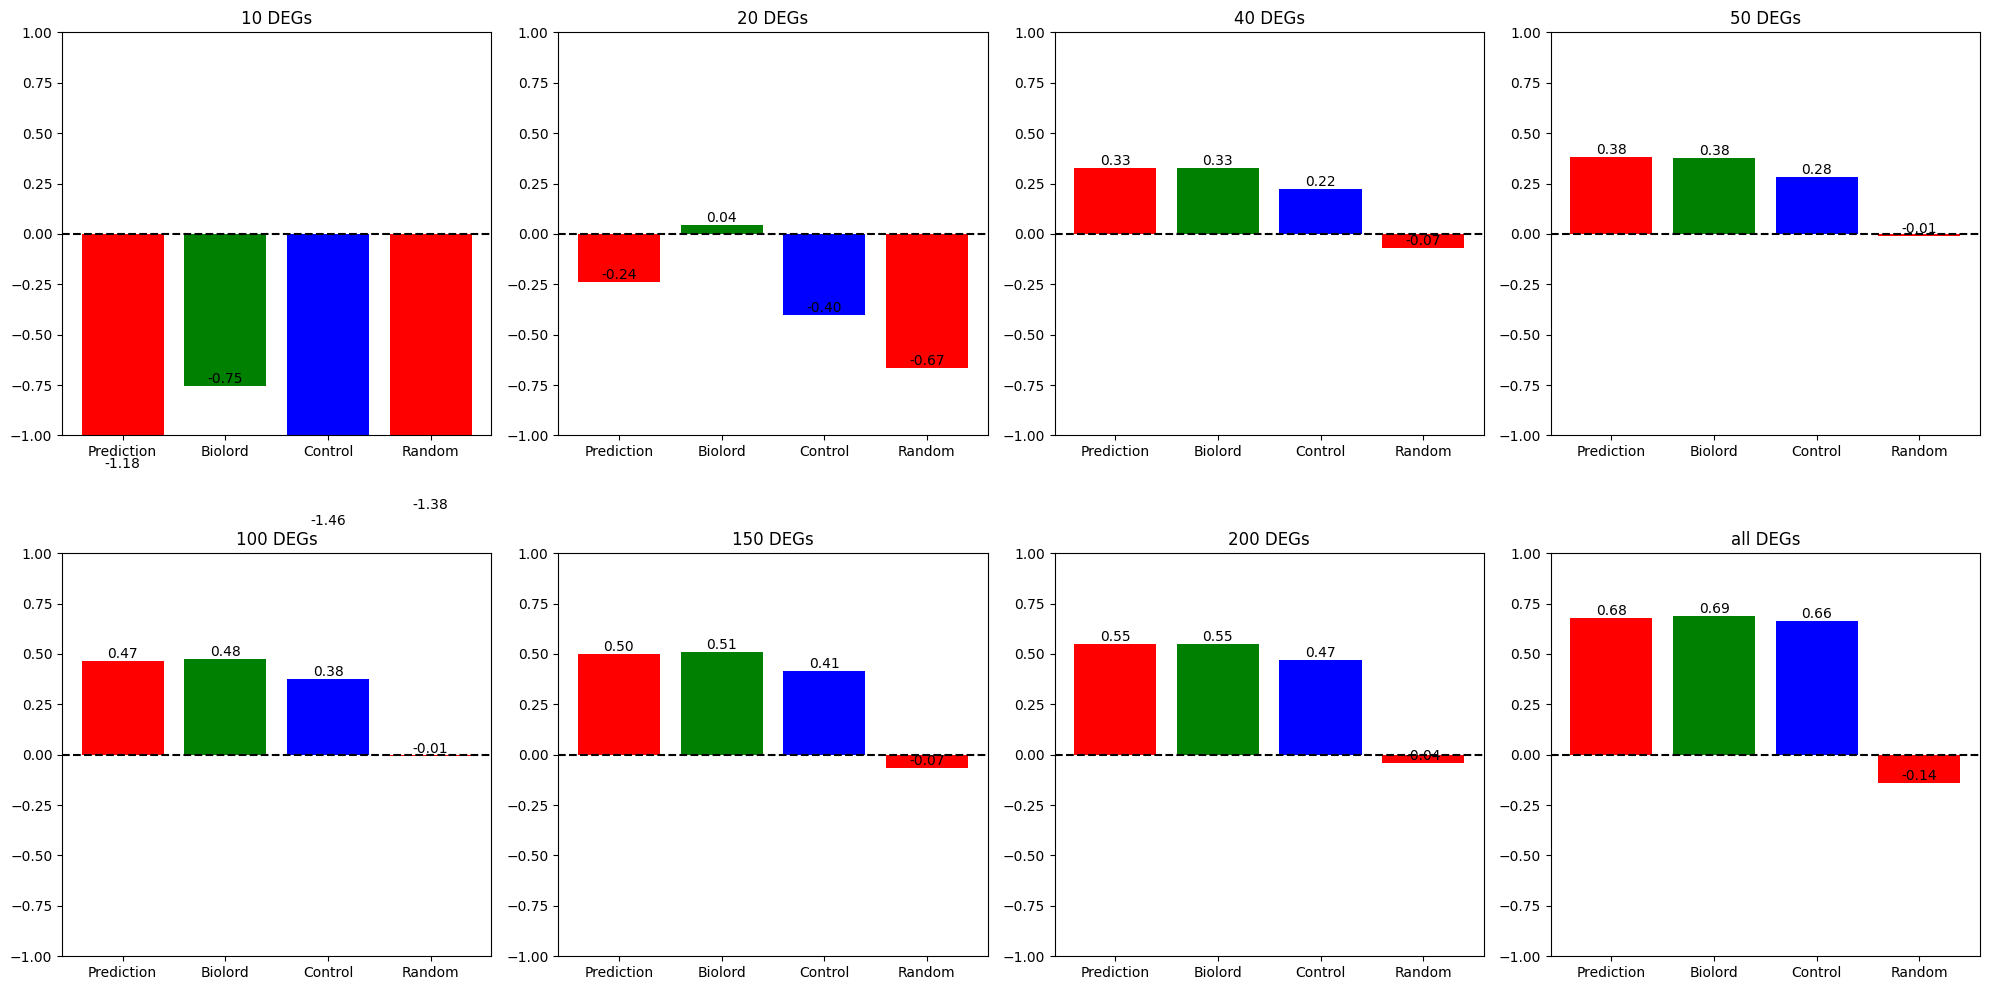

In [166]:
n_rows = r2_results.shape[0]
df = r2_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i in range(n_rows):
    row = df.iloc[i]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns)  # Setting x-axis labels
    ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Displaying the plot

In [164]:
n_rows = r2_var_results.shape[0]
df = r2_var_results
# Plotting each row as a separate bar plot in a 2x4 grid
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i in range(n_rows):
    row = df.iloc[i]  # Extracting the row
    ax = axes[i // 4, i % 4]  # Get the current subplot
    bars = ax.bar(range(len(row)), row, color=['red', 'green', 'blue'])  # Plotting the row values as a bar plot
    ax.axhline(y=0, color='black', linestyle='--')  # Adding a baseline line at y=0
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                '%.2f' % height,
                ha='center', va='bottom')  # Adding value numbers on each bar
    
    ax.set_xticks(range(len(row)))  # Setting x-axis ticks
    ax.set_xticklabels(df.columns)  # Setting x-axis labels
    ax.set_title(f'{r2_results.index[i]} DEGs')  # Setting title
    ax.set_ylim(-1, 1)  # Setting y-axis limit

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()  # Displaying the plot

AttributeError: 'dict' object has no attribute 'shape'

In [123]:
deg_list

['ENSG00000155307',
 'ENSG00000230876',
 'ENSG00000172673',
 'ENSG00000253300',
 'ENSG00000205542',
 'ENSG00000165553',
 'ENSG00000168685',
 'ENSG00000198888',
 'ENSG00000168214',
 'ENSG00000241956',
 'ENSG00000059804',
 'ENSG00000186094',
 'ENSG00000075624',
 'ENSG00000228716',
 'ENSG00000122862',
 'ENSG00000198840',
 'ENSG00000115738',
 'ENSG00000133392',
 'ENSG00000105372',
 'ENSG00000198763',
 'ENSG00000166710',
 'ENSG00000133454',
 'ENSG00000198804',
 'ENSG00000258077',
 'ENSG00000135046',
 'ENSG00000154556',
 'ENSG00000137818',
 'ENSG00000112232',
 'ENSG00000108107',
 'ENSG00000118849',
 'ENSG00000090104',
 'ENSG00000057294',
 'ENSG00000142937',
 'ENSG00000196482',
 'ENSG00000132965',
 'ENSG00000169306',
 'ENSG00000142541',
 'ENSG00000112530',
 'ENSG00000140988',
 'ENSG00000109472',
 'ENSG00000169442',
 'ENSG00000118997',
 'ENSG00000057657',
 'ENSG00000182601',
 'ENSG00000167526',
 'ENSG00000182256',
 'ENSG00000149273',
 'ENSG00000092969',
 'ENSG00000162511',
 'ENSG00000112936',
